# Using Tabula Sapiens as a reference for annotating new datasets

This notebook allows you to annotate your data with a number of annotation methods using the Tabula Sapiens dataset as the reference. 

Initial setup: 
1. Make sure GPU is enabled (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU)
2. We also highly recommend getting Colab PRO for access to a high ram session.


Integration Methods Provided:
- scVI [(Lopez et al. 2018)](https://www.nature.com/articles/s41592-018-0229-2)
- bbKNN [(Polański et al. 2020)](https://academic.oup.com/bioinformatics/article/36/3/964/5545955)
- Scanorama [(He et al. 2019)](https://www.nature.com/articles/s41587-019-0113-3)

Annotation Methods:
- KNN on integrated spaces
- scANVI [(Xu et al. 2021)](https://www.embopress.org/doi/full/10.15252/msb.20209620)
- onClass [(Wang et al. 2020)](https://www.biorxiv.org/content/10.1101/810234v2)
- SVM 
- RandomForest

To use the notebook, simply connect to your Google Drive account, set the necessary arguments, select your methods, and run all the code blocks!

**User action is only required in Steps 1-3.**

Last edited: 6/27/2021



## Step 1: Setup environment

We omit the output of those lines for readability.

In [1]:
%%capture
clone_github_repo = False # Set to True if running outside of already exisiting Github repository.
if clone_github_repo:
    !git clone --quiet https://github.com/czbiohub/PopV.git

# Restart the Runtime after installation (User Action Required)

Runtime -> "Restart runtime"

In [2]:
%%capture
# Restart the runtime before running this cell
import anndata
import popv
import numpy as np
import scanpy as sc
import os

2023-01-26 15:19:59.856330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 15:20:04.441552: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-26 15:20:04.441713: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-26 15:20:04.441728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

# Step 2: Load your data (User Action Required)
Here we provide three options to load your data:
1. Connect to Google Drive (highly recommended)
2. Download your data from the cloud and save into this session or on Google drive.
3. Upload your data manually into this session (files are not persistent and will be deleted when session is closed)

As an example, we use a subsampled version of the [Lung Cell Atlas](https://hlca.ds.czbiohub.org/) \[1] for our query data.

\[1] Travaglini, K. et al. A molecular cell atlas of the human lung from single-cell RNA sequencing. *Nature* **587**, 619–625(2020).

In [3]:
input_file ={'source': 'wget', 'path': 'tmp_testing/LCA.h5ad', 'link': 'https://www.dropbox.com/s/mrf8y7emfupo4he/LCA.h5ad?dl=1'}

if input_file['source']== 'gdrive':
  # OPTION 1: Connect to Google Drive
  # This is the recomended method especially for large datasets
  from google.colab import drive    
  drive.mount('/content/drive')
  query_adata = anndata.read(input_file['path'])
elif input_file['source'] == 'local':
  # OPTION 2: Uploading data manually
  # Click the folder icon on the left navigation bar, and select the upload icon
  # Note: Manually uploaded data is automatically deleted when the colab session ends
  # This is not recommended if your dataset is very large
  query_adata = anndata.read(input_file['path'])
else:
  # OPTION 3: Downloading from the cloud (Dropbox, AWS, Google Drive, etc)
  # Google Colab supports wget, curl, and gdown commands
  # It is recommended to download the data into Google Drive and read from there.
  # This way your data will be persistent.
  print('downloading')
  try:
    !wget -O {input_file['path']} {input_file['link']}
    query_adata = anndata.read(input_file['path'])
  except:
    raise Exception(f'Default download failed with wget. Use custom downloader or check provided link ' + input_file['link'])
    
query_adata.obs_names_make_unique()
query_adata.var_names = query_adata.var_names.str.upper()

downloading
--2023-01-26 15:20:21--  https://www.dropbox.com/s/mrf8y7emfupo4he/LCA.h5ad?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/mrf8y7emfupo4he/LCA.h5ad [following]
--2023-01-26 15:20:21--  https://www.dropbox.com/s/dl/mrf8y7emfupo4he/LCA.h5ad
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce31535f946fefd8a012289ea4c.dl.dropboxusercontent.com/cd/0/get/B1UCUwPWEHGDBDr7VwrEf0_Zu7GsWIzCZ-W8EO4m1SFjYoQ0lWa5WRvBenyVH2cgZG1bx0YEIFECxEeml2casi954i6u72-FQiQrgP4h3zYDY2-aKCq4HMzJHqd0AGbPzv-laQ1b8BEAGRoP0W13Pmkrcr8eqIZVrp28pC_opu8UFjwWCnsLNmT3M20NRQcuDWQ/file?dl=1# [following]
--2023-01-26 15:20:21--  https://uce31535f946fefd8a012289ea4c.dl.dropboxusercontent.com/cd/0/get/B1UCUwPWEHGDBDr7VwrEf0_Zu7GsWIzCZ-W8EO4m1SFjYoQ0lWa5WRvBe

# Step 3 (User Action Required): Setting Up Annotation Parameters 

Here is where you set the parameters for the automated annotation.

Arguments:
- **tissue:** Tabula Sapiens tissue to annotate your data with. Available tissues: ["Bladder", "Blood", "Bone_Marrow", "Kidney", "Large_Intestine", "Lung","Lymph_Node", "Pancreas", "Small_Intestine", "Spleen", "Thymus","Trachea", "Vasculature"]
- **save_location:** location to save results to. By default will save to a folder named `annotation_results`. It is highly recommended you provide a Google Drive folder here.
- **query_batch_key:** key in `query_adata.obs` for batch correction. Set to None for no batch correction. 
- **algorithms:** these are the methods to run. By default, will run all methods.
Options: ["knn_on_scvi_pred", "scanvi_pred", "knn_on_bbknn_pred", "svm_pred", "rf_pred", "onclass_pred", "knn_on_scanorama_pred",


Lesser used parameters
- **query_labels_key**: scANVI has the option to use labeled cells in the query dataset during training. To use some prelabeled cells from the query dataset, set `query_labels_key` to the corresponding key in `query_adata.obs`
- **unknown_celltype_label**: If `query_labels_key` is not None, will treat everything not labeled `unknown_celltype_label` as a labeled cell

In [19]:
""" 
tissue options: 
['Bladder','Blood','Bone_Marrow','Fat',
'Heart','Kidney','Large_Intestine','Liver',
'Lung','Lymph_Node','Mammary','Muscle',
'Pancreas','Prostate','Salivary Gland',
'Skin','Small_Intestine','Spleen',
'Thymus','Trachea','Vasculature']
"""
tissue = 'Lung'
save_folder = 'popv_results'

query_batch_key = 'donor_method'
algorithms = None # Uses all algorithms

# Lesser used parameters
query_labels_key=None
unknown_celltype_label='unknown'

# Step 4: Downloading Reference Data and Pretrained Models
No more user input required! Just run all the following code blocks.

**NOTE: PopV has only been evaluated with the Lung as a reference dataset. Other tissue results may vary depending on annotation quality**

In [20]:
# Here we download the necessary data:
if tissue == 'Bladder':
  refdata_url = 'https://www.dropbox.com/s/p5x1lb0jyl8293c/Bladder.h5ad'
  pretrained_url='https://www.dropbox.com/s/1mkyr8wxihzdl9q/Bladder_pretrained_ts.tar.gz'
elif tissue == 'Blood':
  refdata_url = 'https://www.dropbox.com/s/4cg6zj340oelhlg/Blood.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/kkyg8npt3stdfzm/Blood_pretrained_ts.tar.gz'
elif tissue == 'Bone_Marrow':
  refdata_url = 'https://www.dropbox.com/s/rwfovoyafpd64io/Bone_Marrow.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/3sujl4bu195egrd/Bone_Marrow_pretrained_ts.tar.gz'
elif tissue == 'Fat':
  refdata_url = 'https://www.dropbox.com/s/if1d7iloovi8e9o/Fat.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/yxkszhsp9m2vrq8/Fat_pretrained_ts.tar.gz'
elif tissue == 'Heart':
  refdata_url = 'https://www.dropbox.com/s/0udrdzjl2z087jj/Heart.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/wqnugdwoiqq07uv/Heart_pretrained_ts.tar.gz'
elif tissue == 'Kidney':
  refdata_url = 'https://www.dropbox.com/s/8sx9fhjfgnyjgdz/Kidney.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/nwsven5jl8u50ag/Kidney_pretrained_ts.tar.gz'
elif tissue == 'Large_Intestine':
  refdata_url = 'https://www.dropbox.com/s/272sajn0hkj62le/Large_Intestine.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/yz7wxl9xf0lx2q8/Large_Intestine_pretrained_ts.tar.gz'
elif tissue == 'Liver':
  refdata_url = 'https://www.dropbox.com/s/g0ahumalnm0mp38/Liver.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/yjx6y5e1yegu1p5/Liver_pretrained_ts.tar.gz'
elif tissue == 'Lung':
  refdata_url = 'https://www.dropbox.com/s/2kuzdamjevev2ci/Lung.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/nrffb469x0e998h/Lung_pretrained_ts.tar.gz'
elif tissue == 'Lymph_Node':
  refdata_url = 'https://www.dropbox.com/s/tetuh62010uothb/Lymph_Node.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/bon9v9kdeiic7cx/Lymph_Node_pretrained_ts.tar.gz'
elif tissue == 'Mammary':
  refdata_url = 'https://www.dropbox.com/s/krm4pv4ev6cynns/Mammary.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/caocfe4q81ft4va/Mammary_pretrained_ts.tar.gz'
elif tissue == 'Muscle':
  refdata_url = 'https://www.dropbox.com/s/0jhvnoy49rvrlqn/Muscle.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/e8hc2xkv5wns34o/Muscle_pretrained_ts.tar.gz'
elif tissue == 'Pancreas':
  refdata_url = 'https://www.dropbox.com/s/kn0zodnmxwx0yhe/Pancreas.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/ur0efl7knv1qup8/Pancreas_pretrained_ts.tar.gz'
elif tissue == 'Prostate':
  refdata_url = 'https://www.dropbox.com/s/040fb5jr0zcur7h/Prostate.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/7brv5mbtlx87the/Prostate_pretrained_ts.tar.gz'
elif tissue == 'Salivary_Gland':
  refdata_url = 'https://www.dropbox.com/s/rwia1ji7eztga6b/Salivary_Gland.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/sz5lte02sq52lru/Salivary_Gland_pretrained_ts.tar.gz'
elif tissue == 'Skin':
  refdata_url = 'https://www.dropbox.com/s/ucvdksq2jnug2nh/Skin.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/3uieynhqgns0k1u/Skin_pretrained_ts.tar.gz'
elif tissue == 'Small_Intestine':
  refdata_url = 'https://www.dropbox.com/s/06ia5n2yex3dq8j/Small_Intestine.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/1fl512zgir8jeia/Small_Intestine_pretrained_ts.tar.gz'
elif tissue == 'Spleen':
  refdata_url = 'https://www.dropbox.com/s/m2d0gme847qdhr1/Spleen.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/8nkgdet282hpdra/Spleen_pretrained_ts.tar.gz'
elif tissue == 'Thymus':
  refdata_url = 'https://www.dropbox.com/s/i84bcyk87scesml/Thymus.h5ad'
  pretrained_url='https://www.dropbox.com/s/lrtvnitoahyi89l/Thymus_pretrained_ts.tar.gz'
elif tissue == 'Trachea':
  refdata_url = 'https://www.dropbox.com/s/ppt7b6w73gvceap/Trachea.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/5jqfb0eghi9w7w7/Trachea_pretrained_ts.tar.gz'
elif tissue == 'Vasculature':
  refdata_url = 'https://www.dropbox.com/s/1eq0zamel5etmoq/Vasculature.h5ad'
  pretrained_url='https://www.dropbox.com/s/gxh8x8hklk5u8bq/Vasculature_pretrained_ts.tar.gz'

# Download pretrained scVI and scANVI models.
output_fn = 'tmp_testing{}.tar'.format(tissue)
!wget -O $output_fn $refdata_url
if not os.path.exists(f'tmp_testing/pretrained_models_new/{tissue}'):
   os.makedirs(f'tmp_testing/pretrained_models_new/{tissue}')
!wget -O $output_fn $pretrained_url
!tar -C tmp_testing/pretrained_models_new/$tissue -xf $output_fn

--2023-01-26 15:10:09--  https://www.dropbox.com/s/nrffb469x0e998h/Lung_pretrained_ts.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/nrffb469x0e998h/Lung_pretrained_ts.tar.gz [following]
--2023-01-26 15:10:10--  https://www.dropbox.com/s/raw/nrffb469x0e998h/Lung_pretrained_ts.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccaa0f3b8c87f646cc81a14a1bc.dl.dropboxusercontent.com/cd/0/inline/B1V9UmdiHm9igTEN5FSo727vdbP25jcCNj13vnHkDHUCPJ4subNSgb4Vv-b_T62_4ehJnhUgqFav-Fe14F5G_UoMDIPjUVEiB-TOdGGMe61GU2MlIouoXG3Xbw7SM5YSweFqlLWjll-TyI1tpw9wkm-6BAvfcOI2SUo9eMpyAIvH6A/file# [following]
--2023-01-26 15:10:10--  https://uccaa0f3b8c87f646cc81a14a1bc.dl.dropboxusercontent.com/cd/0/inline/B1V9UmdiHm9igTEN5FSo727vdbP25jcCNj13vnHkD

In [21]:
# read in the reference dataset
ref_adata_path = 'tmp_testing/TS_{}.h5ad'.format(tissue)
ref_adata = anndata.read(ref_adata_path)

### Setup reference data

In [22]:
# Following parameters are specific to Tabula Sapiens dataset and contain the annotated cell-type and the batch_key that are corrected for during model training.
ref_labels_key="cell_ontology_class"
ref_batch_key = ["method", "donor", "10X_run"]

In [23]:
min_celltype_size = np.min(ref_adata.obs.groupby(ref_labels_key).size())
n_samples_per_label = np.max((min_celltype_size, 500))

### Preprocess query with ref dataset


In [24]:
ref_adata = ref_adata[np.random.choice(ref_adata.obs_names, 1000, replace=False)]
query_adata = query_adata[np.random.choice(query_adata.obs_names, 1000, replace=False)]

In [ ]:
ref_adata

In [10]:
ls pretrained_models_new/$tissue

celltypist.pkl               OnClass.index      scanvi/
checkpoint                   OnClass.meta       scvi/
obo_dag.pkl                  OnClass.npz        scvi_knn_classifier.pkl
OnClass.data-00000-of-00001  rf_classifier.pkl  svm_classifier.pkl


In [11]:
from popv.preprocessing import Process_Query

adata = Process_Query(
        query_adata,
        ref_adata,
        query_labels_key=query_labels_key,
        query_batch_key=query_batch_key,
        ref_labels_key=ref_labels_key,
        ref_batch_key=ref_batch_key,
        unknown_celltype_label=unknown_celltype_label,
        save_path_trained_models=f'pretrained_models_new/{tissue}/',
        prediction_mode='inference', # 'fast' mode gives fast results (does not include BBKNN and Scanorama and makes more inaccurate errors)
        n_samples_per_label=n_samples_per_label,
        use_gpu=True,
        compute_embedding=True,
        hvg=None
    ).adata

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
adata.uns['_prediction_mode']

'inference'

# Step 5: Run Automated Cell Annotation Methods
No user action required. 

Your results will be saved to the folder you provided as **save_folder**.

All results are stored in adata.obs
- The column `popv_prediction` contains the end popv prediction. 
- `popv_prediction_score` contains the score for the popv_prediction, which is a measure of the number of methods that agreed with the resulting prediction. We use the cell ontology when aggregating results.
- We also include the majority vote, which simply takes the celltype that was most often predicted by the individual methods.

In [11]:
from popv.annotation import annotate_data

annotate_data(adata, save_path=save_folder)

Found 4000 genes among all datasets
[[0.00000000e+00 7.44444444e-01 8.15596330e-01 1.14678899e-01
  1.05504587e-01 3.66972477e-03 4.01304239e-03 2.56880734e-02
  0.00000000e+00 1.19266055e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.31481481e-01 3.05555556e-02
  2.22222222e-02 9.25925926e-04 1.85185185e-03 4.62962963e-03
  0.00000000e+00 3.70370370e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.81651376e-02
  1.55963303e-01 1.74311927e-02 2.24770642e-02 2.47706422e-02
  0.00000000e+00 1.28440367e-02 0.00000000e+00 4.35413643e-03
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.73893112e-01 7.51231527e-02 5.71858540e-02 1.09201375e-01
  6.11060189e-03 9.99280518e-02 6.97999069e-03 3.06240929e-01
  4.10654828e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.24281609e-01 1.00326060e-01 7.62490570e-02
  3.66636114e-03 1.21917


# Optional: save the full anndata will all objects

In [12]:
adata

AnnData object with n_obs × n_vars = 110753 × 4000
    obs: '10X_run', 'pilot', 'tissue', 'subtissue', 'method', '10X_sample', '10X_replicate', 'notes', 'seqrun', 'donor', 'anatomical_position', '10X_barcode', 'cDNAplate', 'libraryplate', 'well', 'donor_method', 'computational_compartment_assignment', 'tissue_cell_type', 'cell_type_tissue', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'cell_ontology_type', 'cell_ontology_id', '_dataset', 'n_counts', 'popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'subsampled_labels', '_scvi_batch', '_scvi_labels', 'popv_knn_on_scvi_prediction', '_labels_annotation_cell_ontology_id', 'popv_onclass_prediction', 'onclass_seen', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction', 'popv_majority_vote_prediction', 'popv_majority_vote_score', 'popv_prediction', 'popv_prediction_score', 'popv_predic

In [13]:
# adata.write('query_and_reference_popv.h5ad')

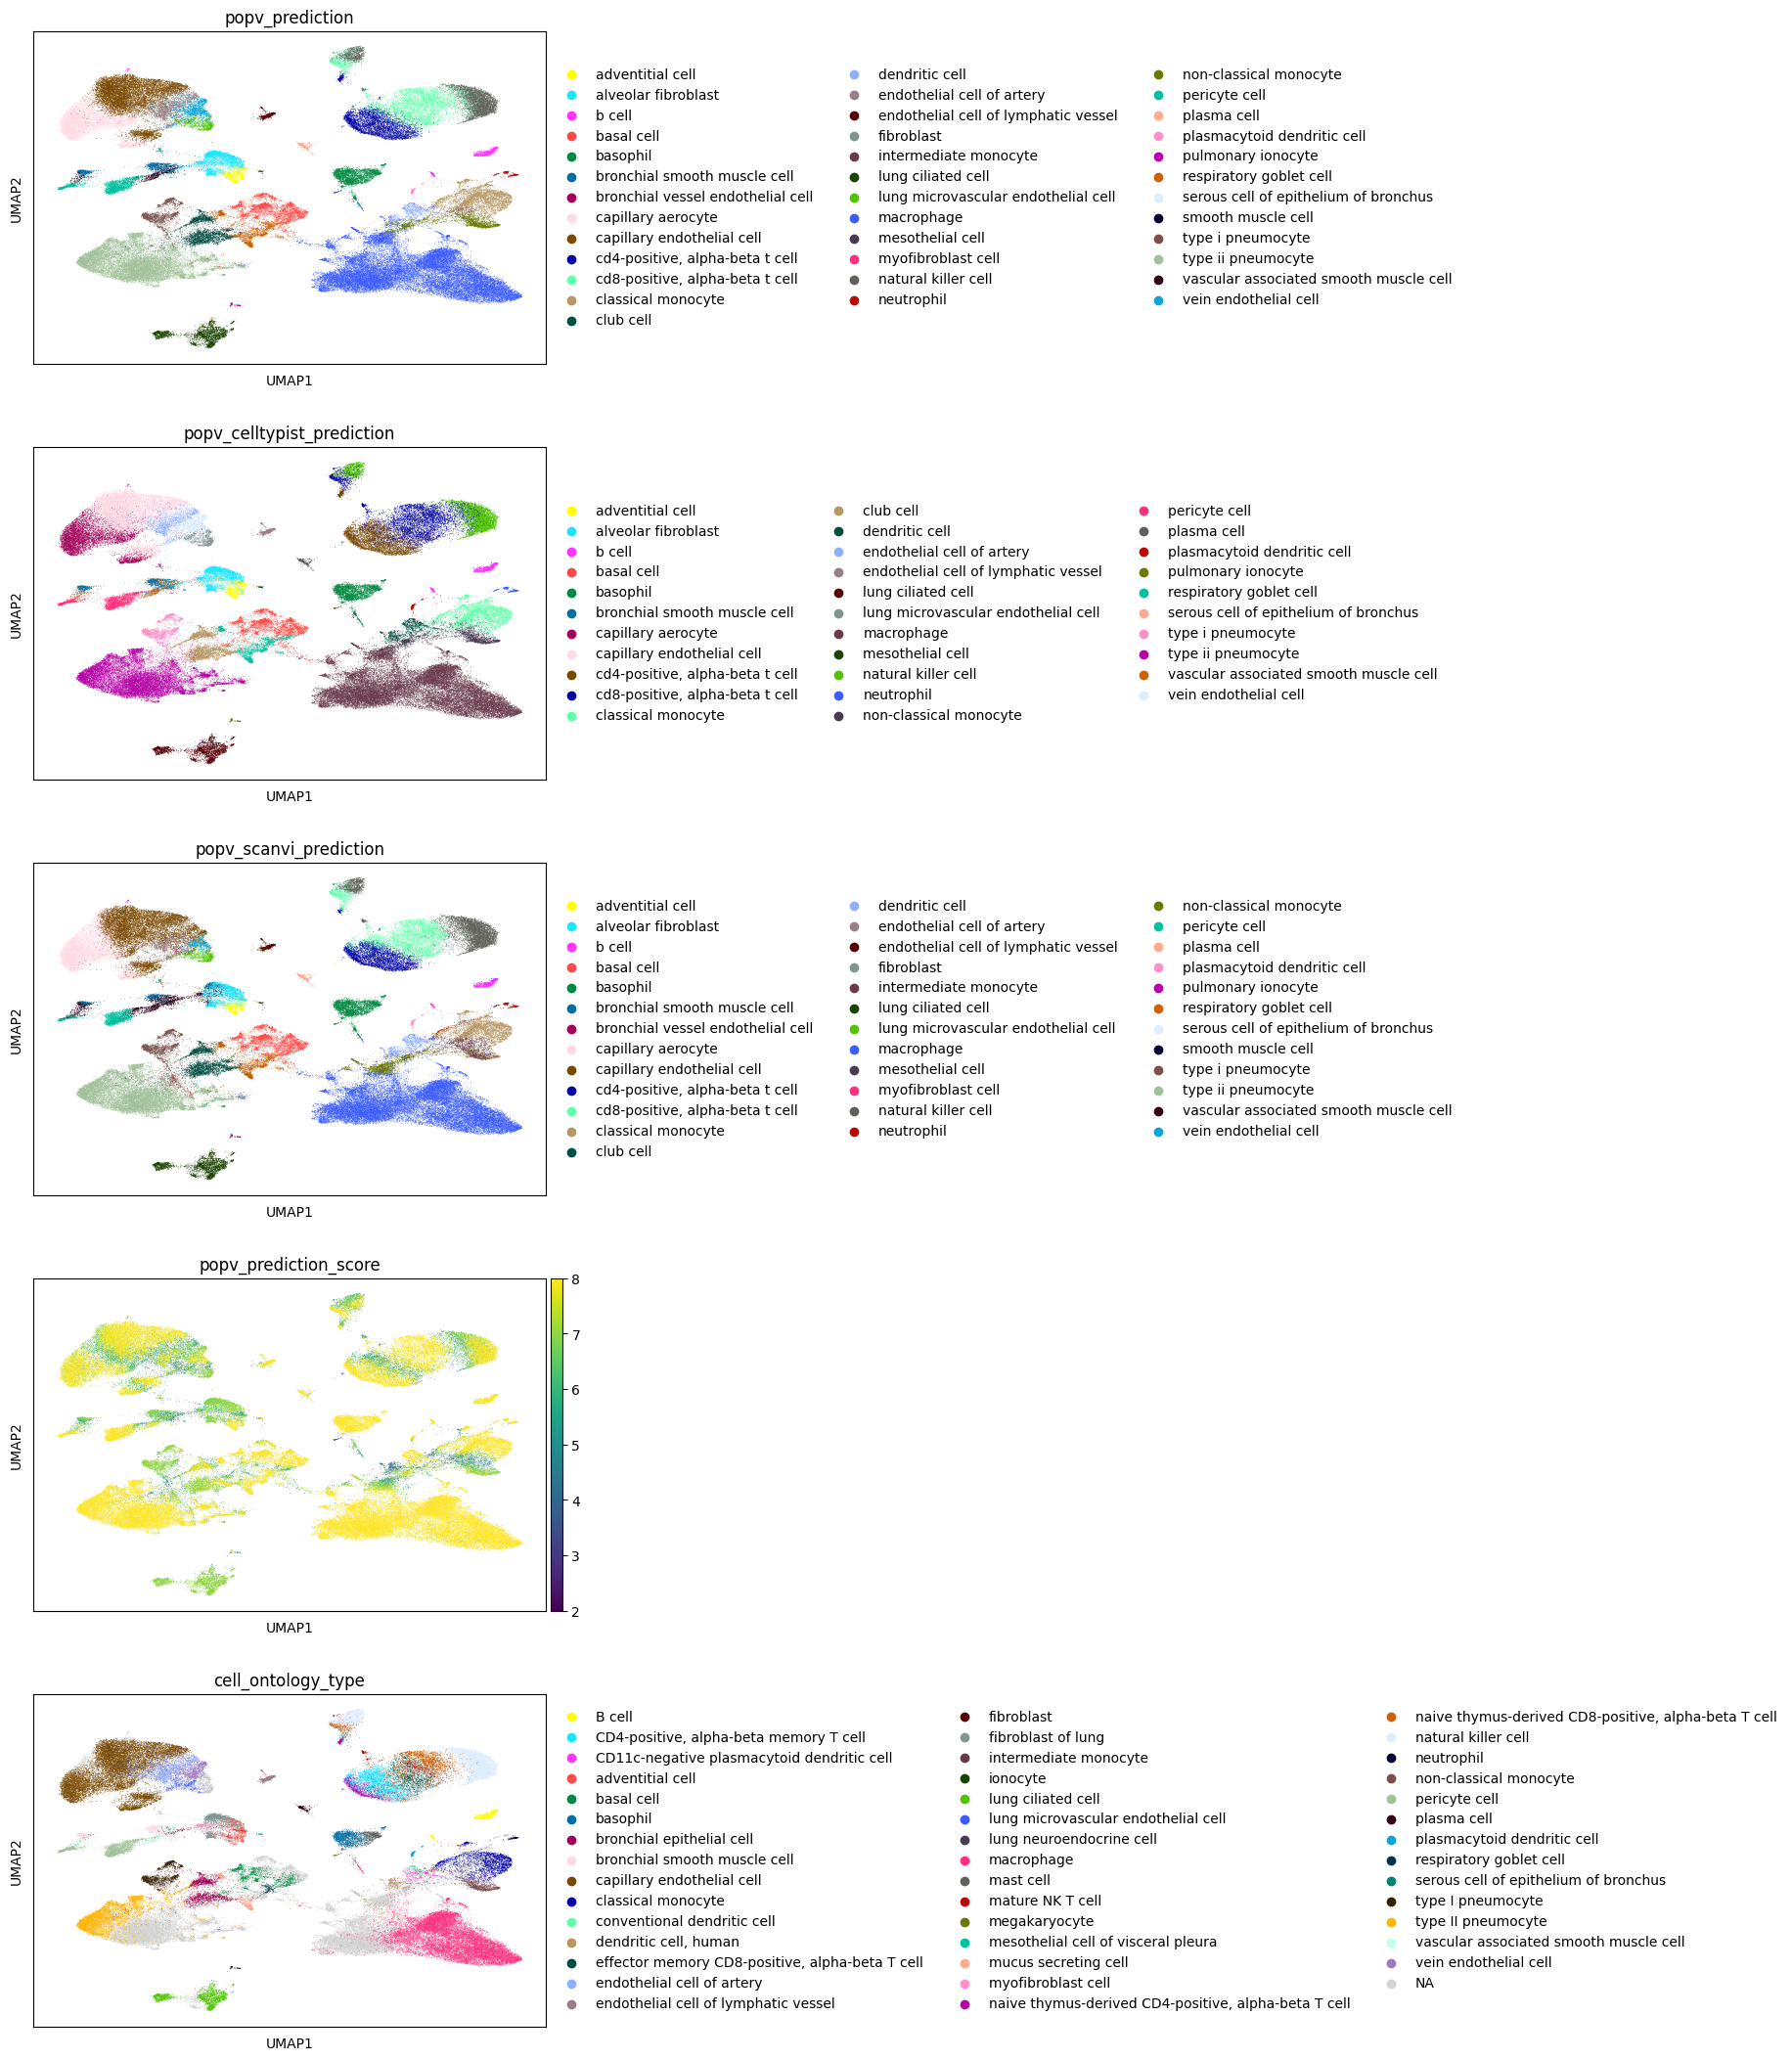

In [15]:
adata.obsm['X_umap'] = adata.obsm['X_scanvi_umap_popv']

sc.pl.umap(adata,
           color=['popv_prediction', 'popv_celltypist_prediction', 'popv_scanvi_prediction', 'popv_prediction_score', 'cell_ontology_type'], ncols=1)

# Step 6: Summary Statistics

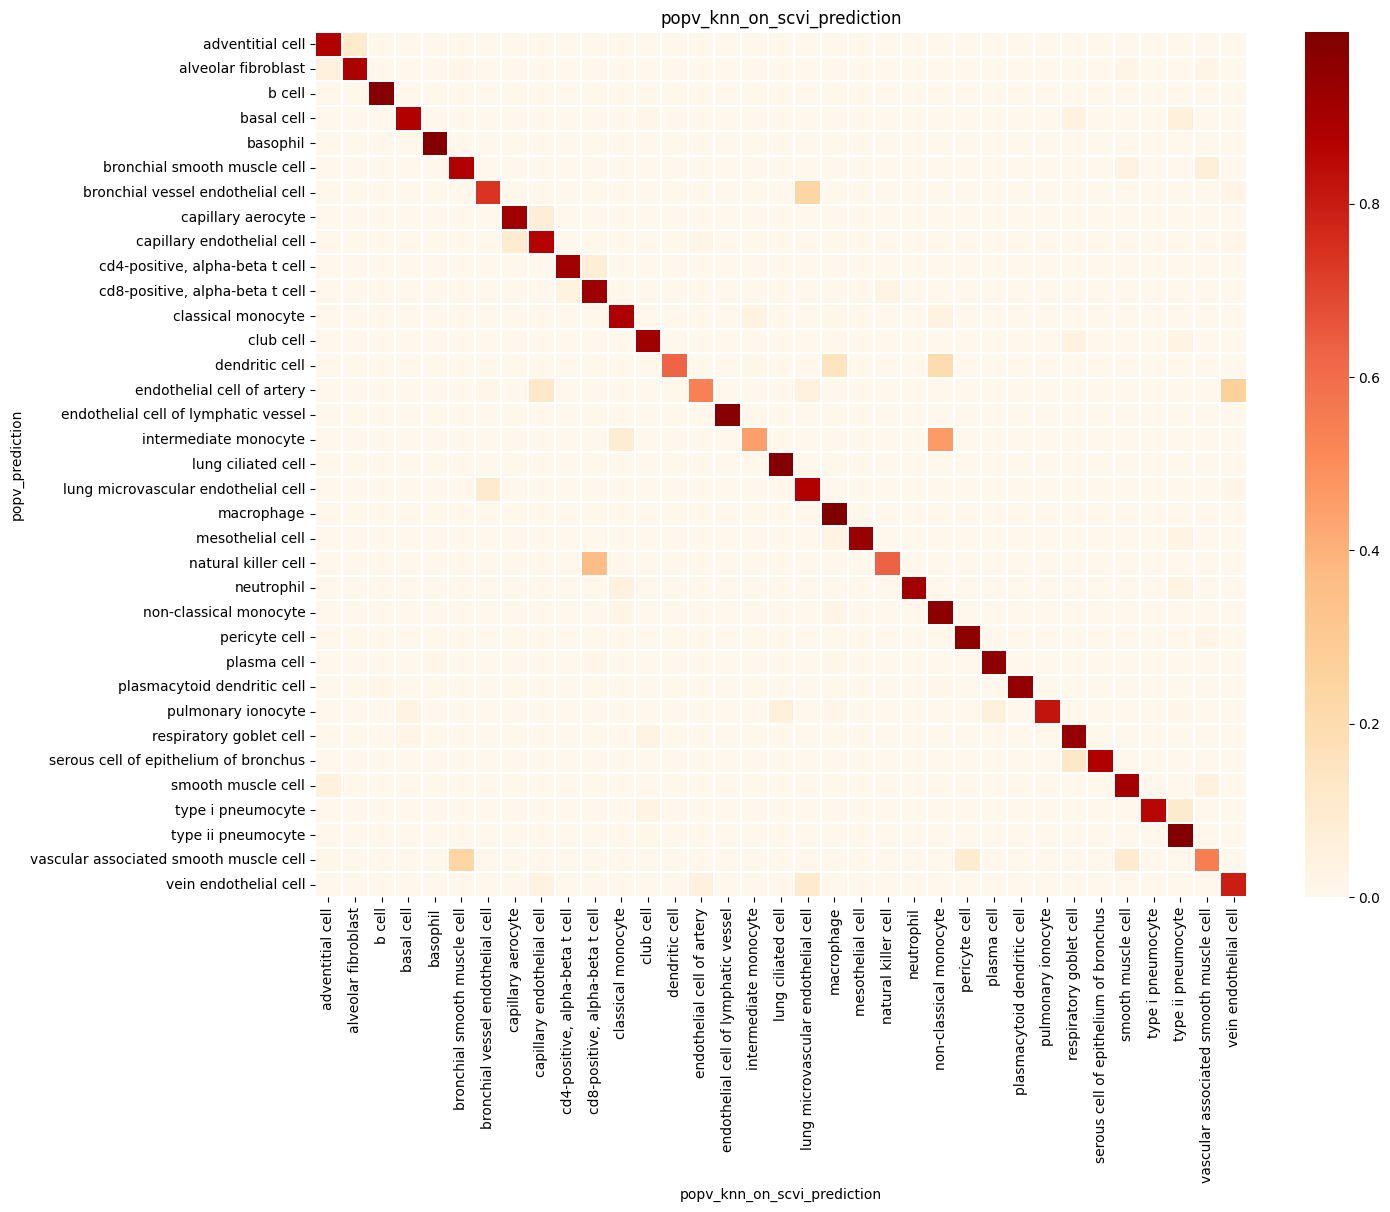

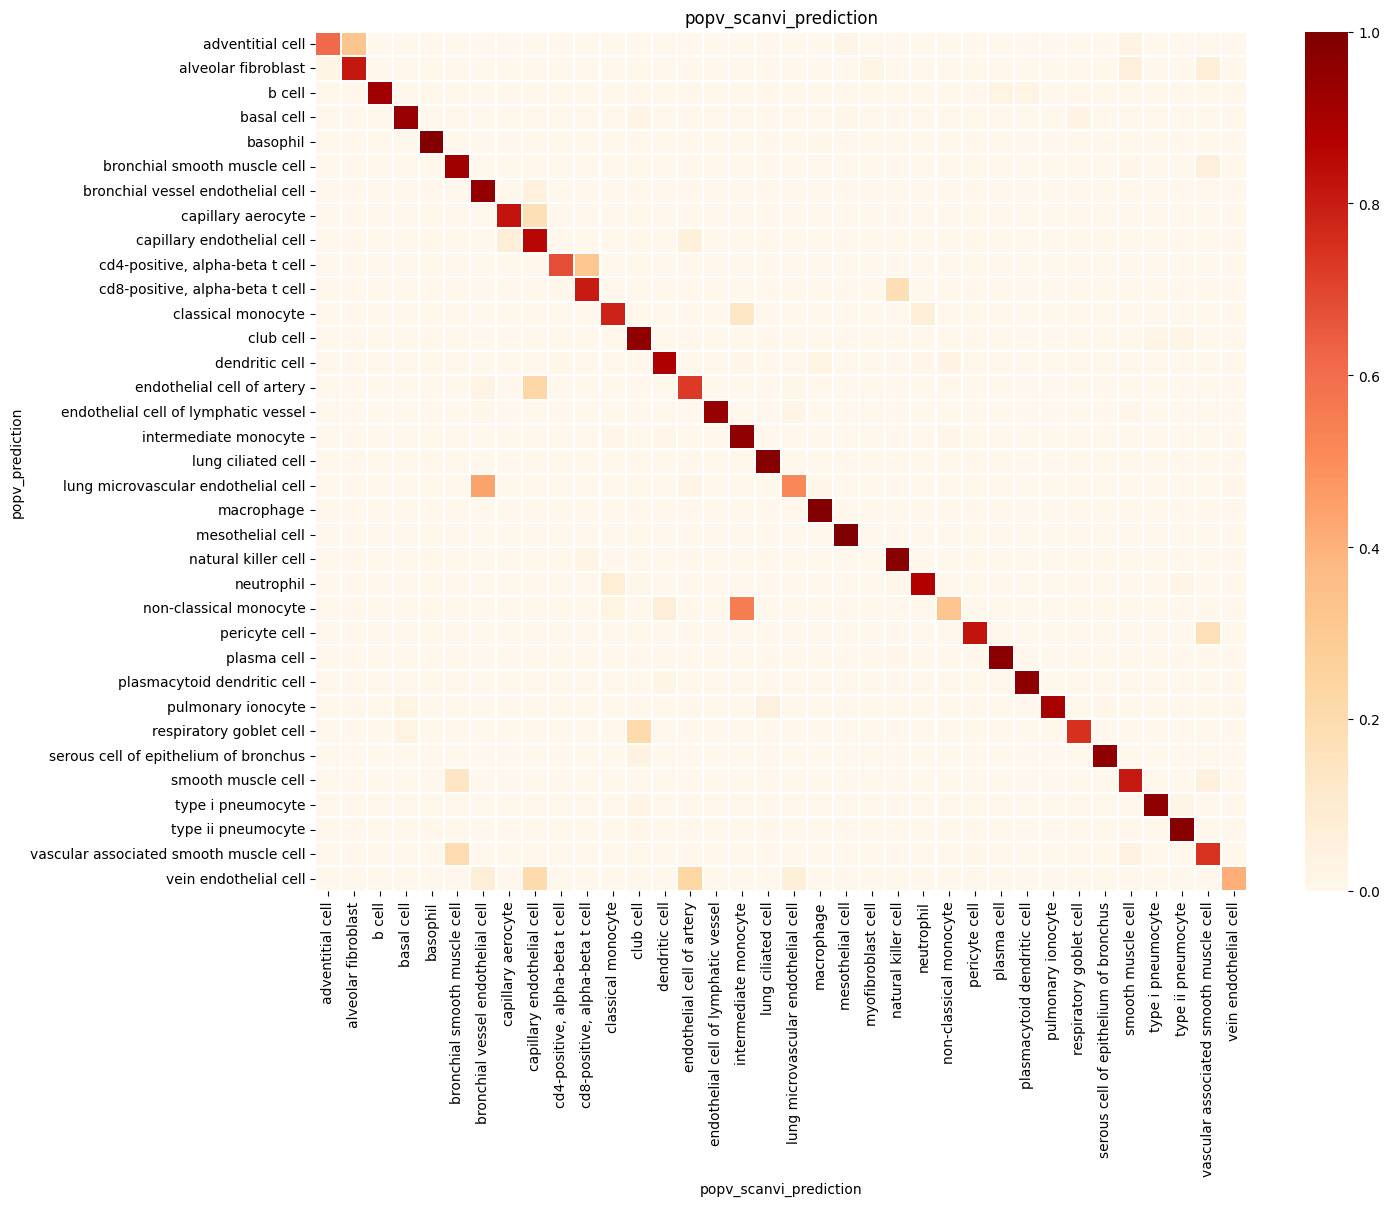

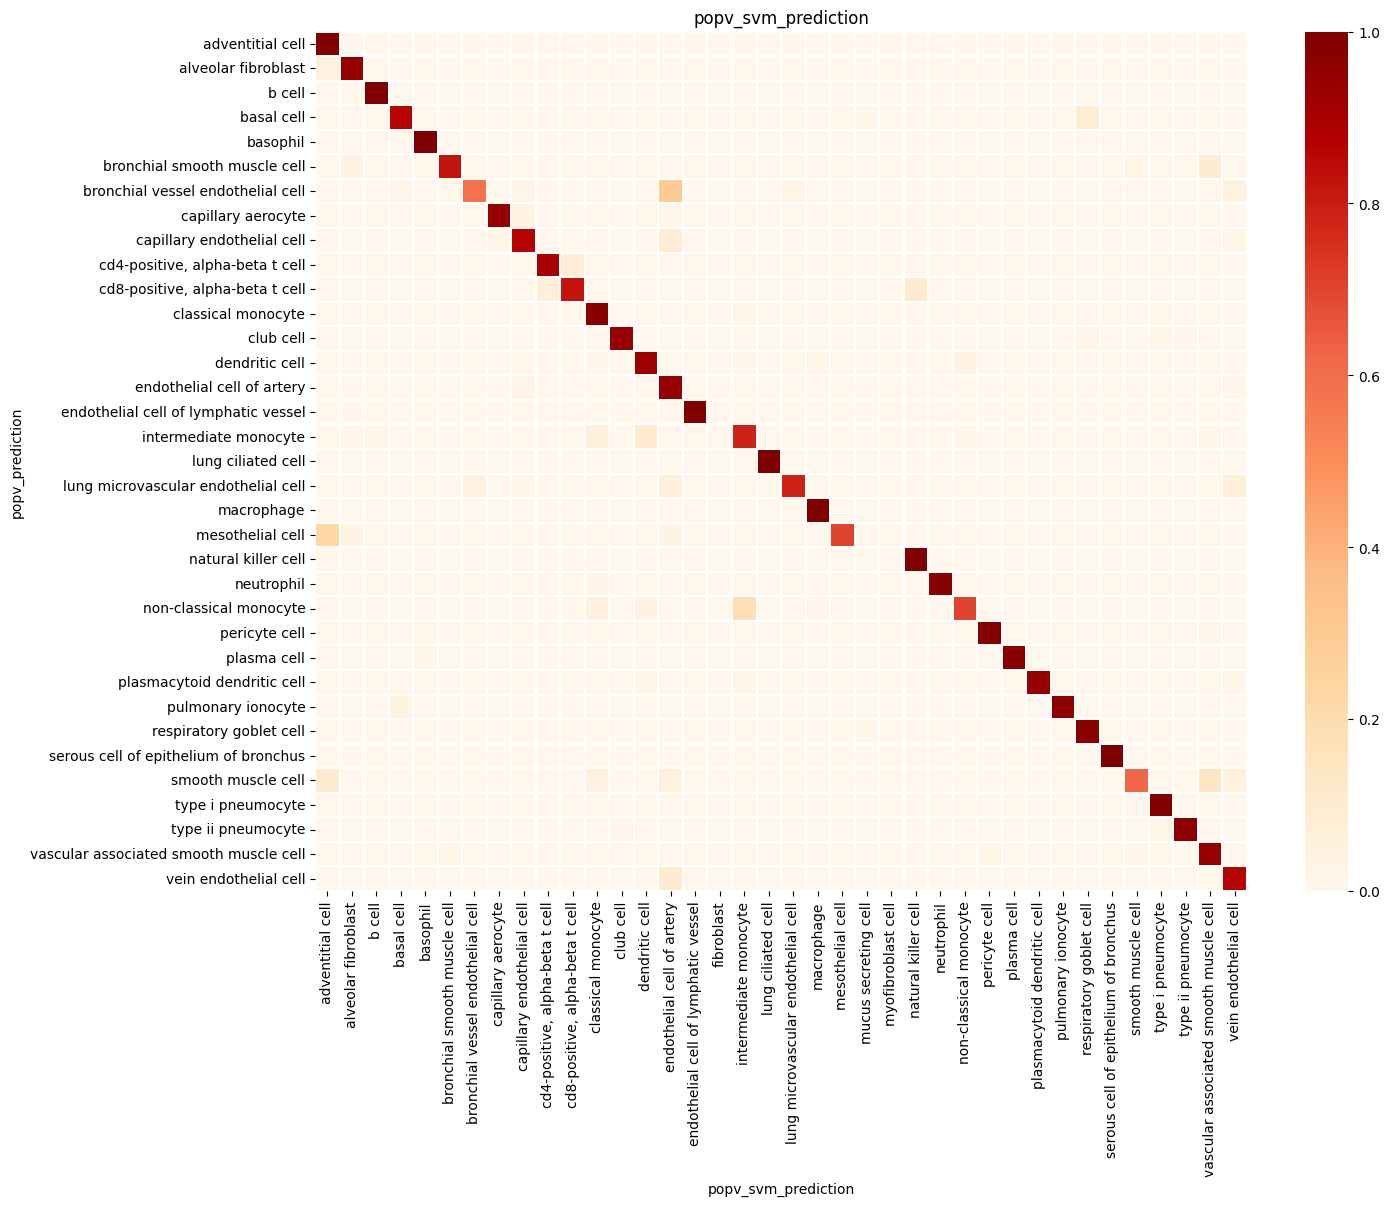

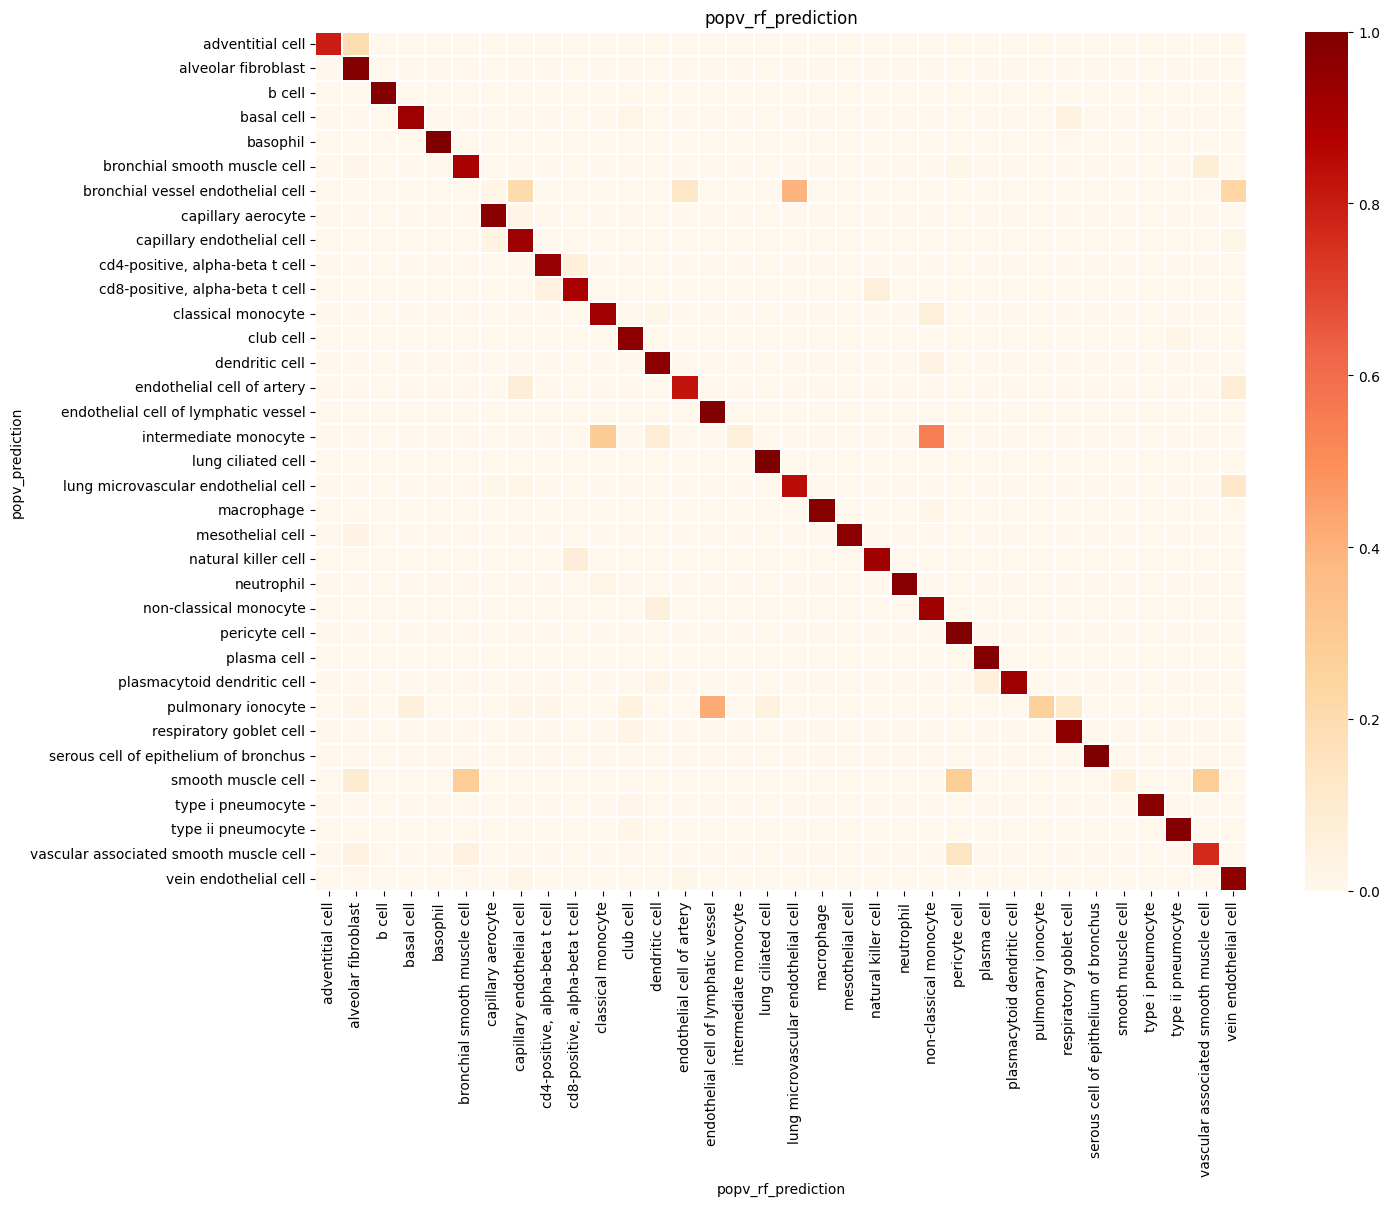

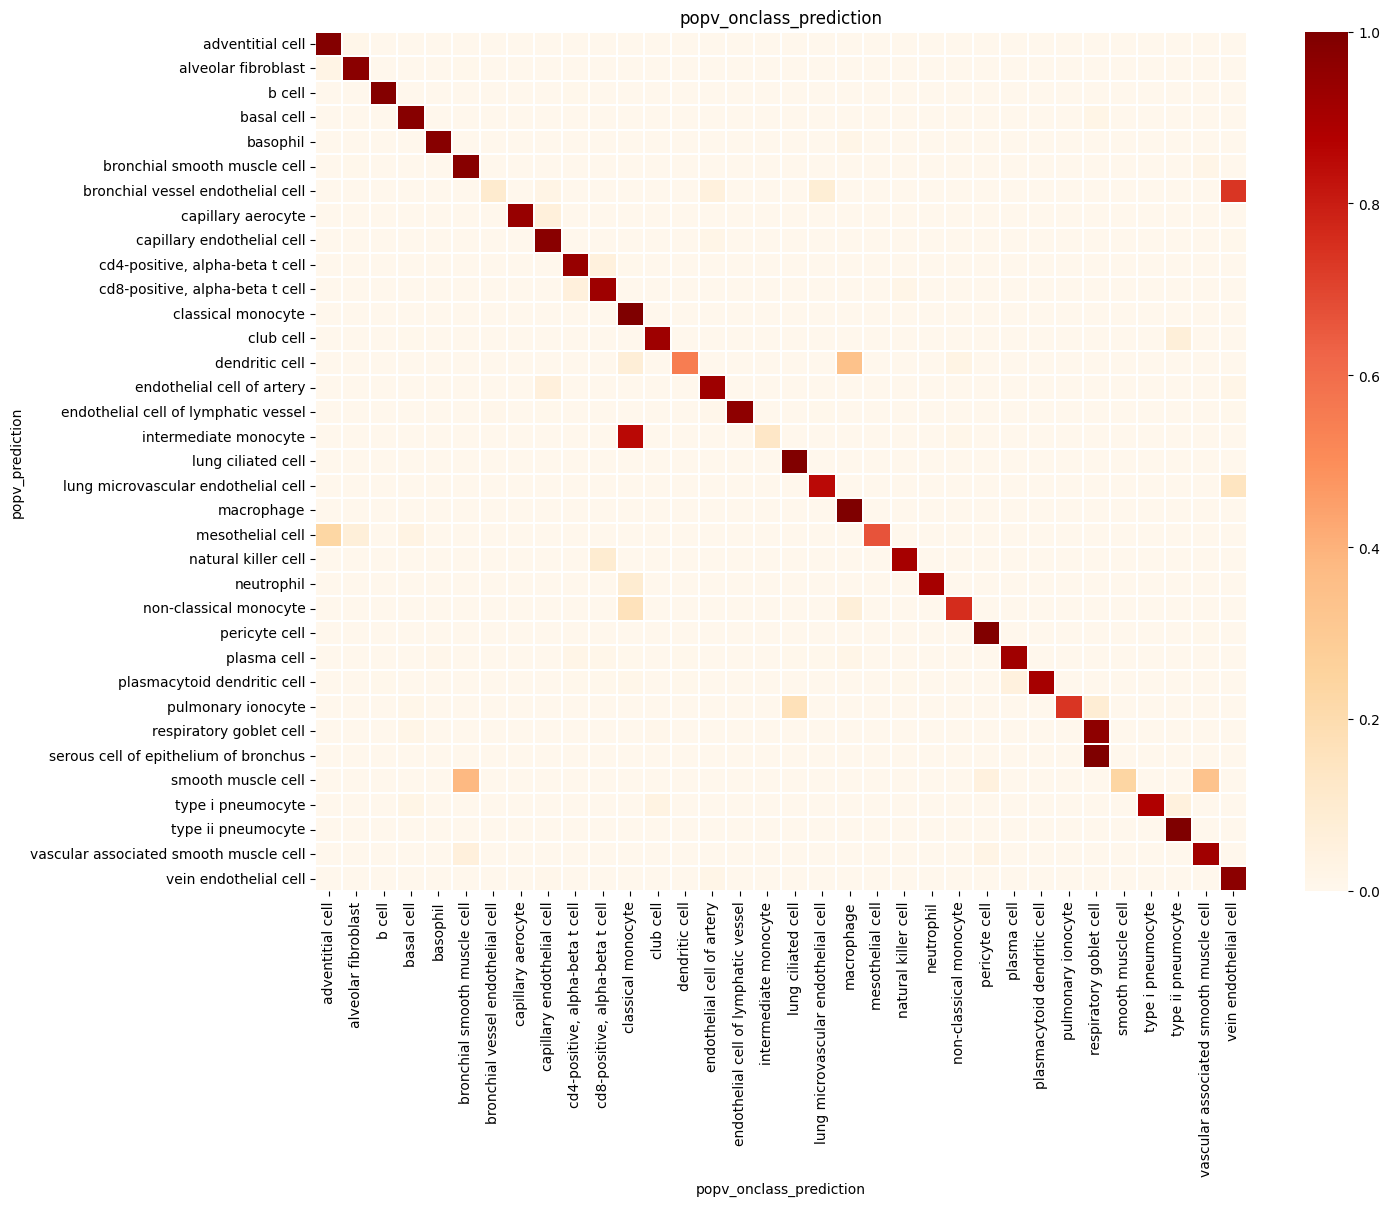

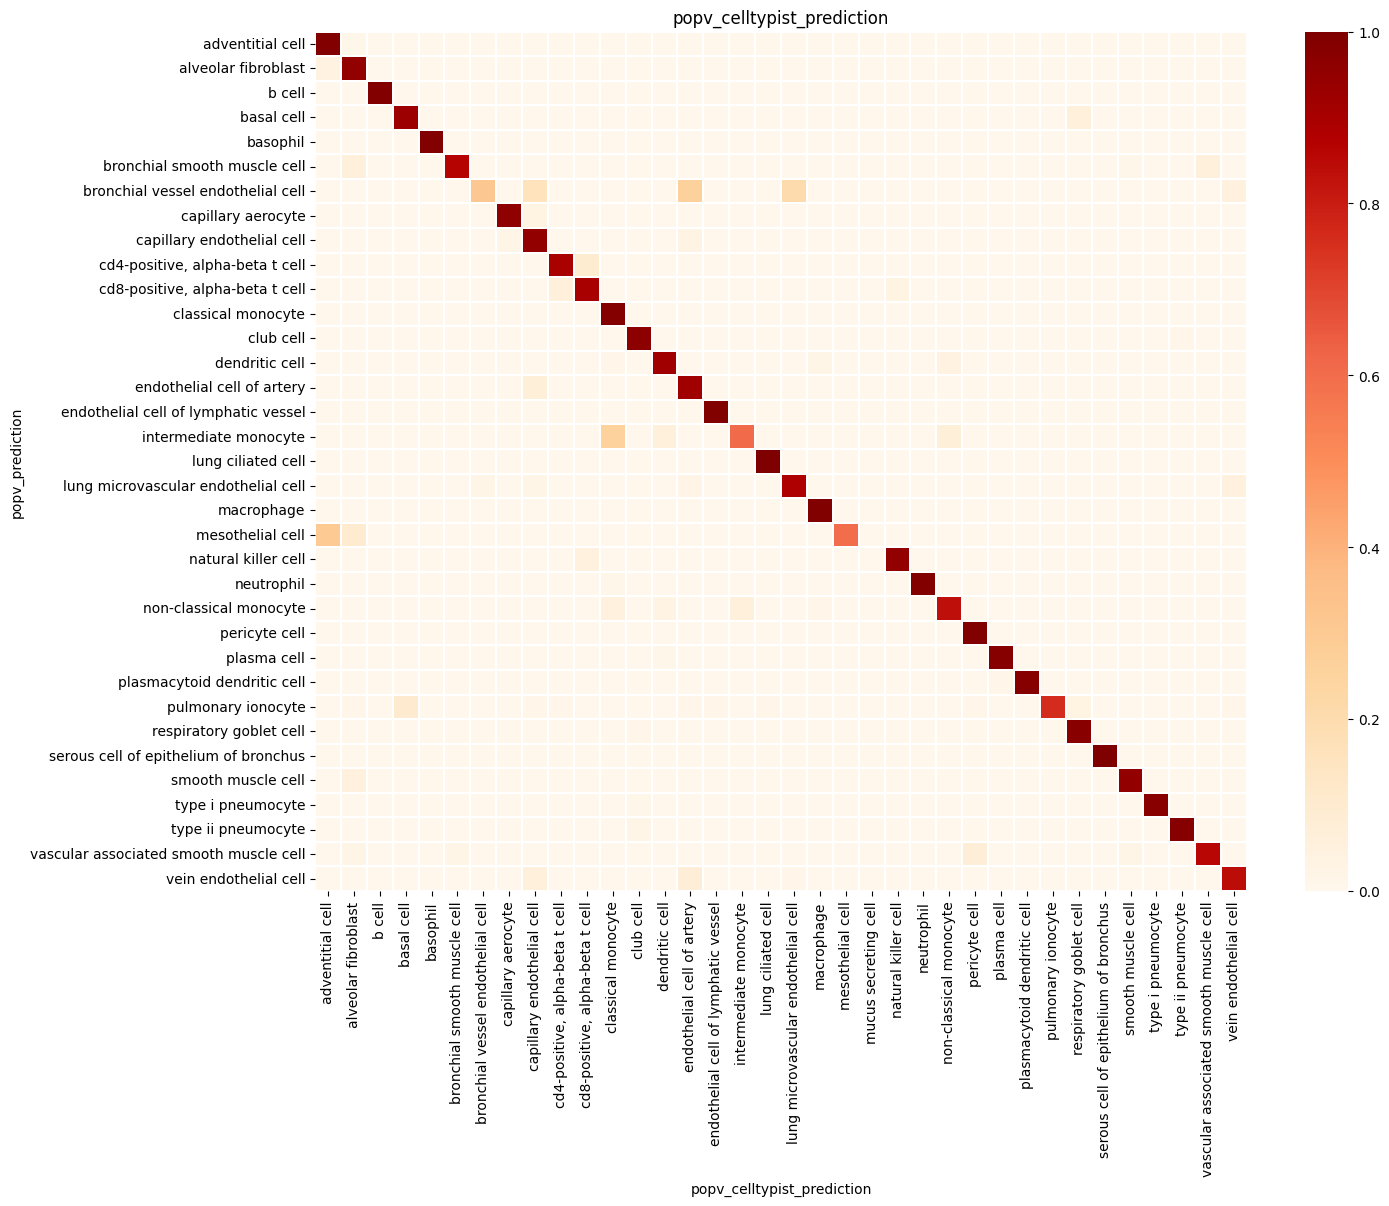

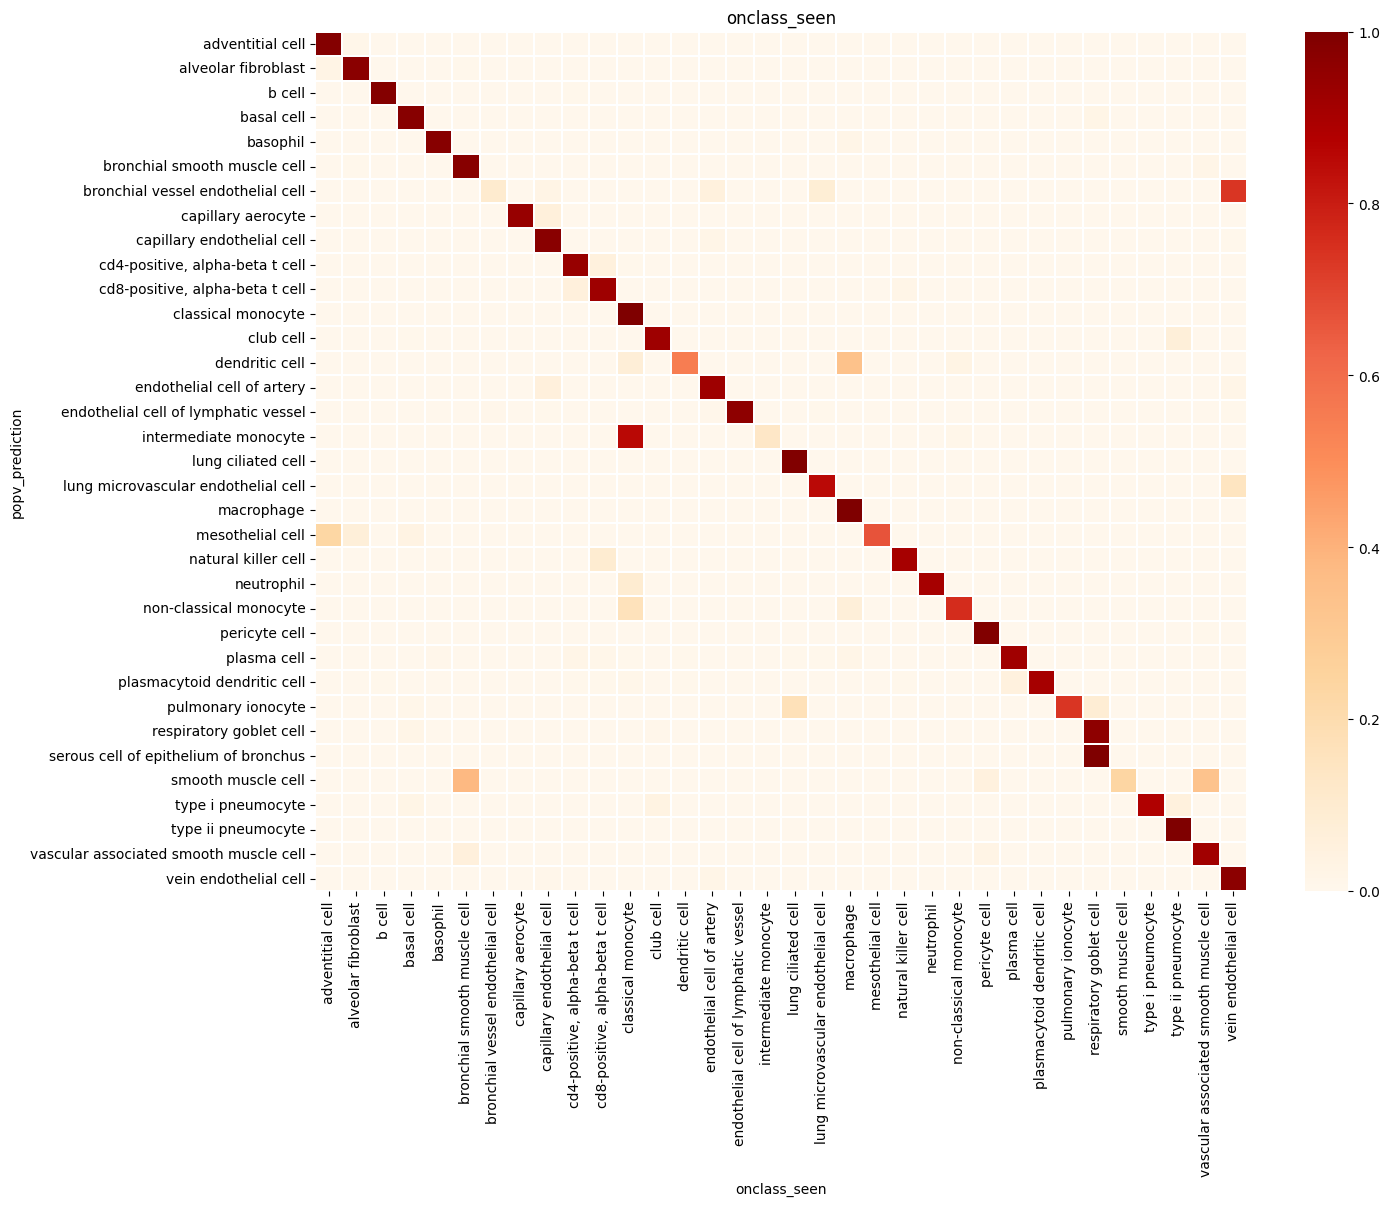

In [ ]:
popv.visualization.make_agreement_plots(adata, prediction_keys=adata.uns['prediction_keys'] + ['onclass_seen'], save_folder=save_folder)

In [ ]:
adata

AnnData object with n_obs × n_vars = 75071 × 4000
    obs: 'method', 'donor', 'cell_ontology_type', 'donor_method', 'cell_ontology_id', '_batch_annotation', '_labels_annotation', '_ref_subsample', '_dataset', 'n_counts', 'subsampled_labels', '_scvi_batch', '_scvi_labels', 'popv_knn_on_scvi_prediction', 'popv_knn_on_scvi_prediction_probabilities', 'popv_scanvi_prediction', 'popv_scanvi_prediction_probabilities', 'popv_svm_prediction', 'popv_svm_prediction_probabilities', 'popv_rf_prediction', 'popv_rf_prediction_probabilities', '_labels_annotation_cell_ontology_id', 'popv_onclass_prediction', 'onclass_seen', 'popv_celltypist_prediction', 'popv_celltypist_prediction_probabilities', 'popv_majority_vote_prediction', 'popv_majority_vote_score', 'popv_prediction', 'popv_prediction_score', 'popv_prediction_depth'
    uns: 'Filtered_cells', 'log1p', 'unknown_celltype_label', '_pretrained_scvi_path', '_save_path_trained_models', '_prediction_mode', '_cl_obo_file', '_cl_ontology_file', '_nlp_emb

In [ ]:
adata.obs['subsampled_labels'].value_counts()

unknown    75071
Name: subsampled_labels, dtype: int64

<AxesSubplot: title={'center': 'PopV Prediction Score'}, xlabel='Score', ylabel='Frequency'>

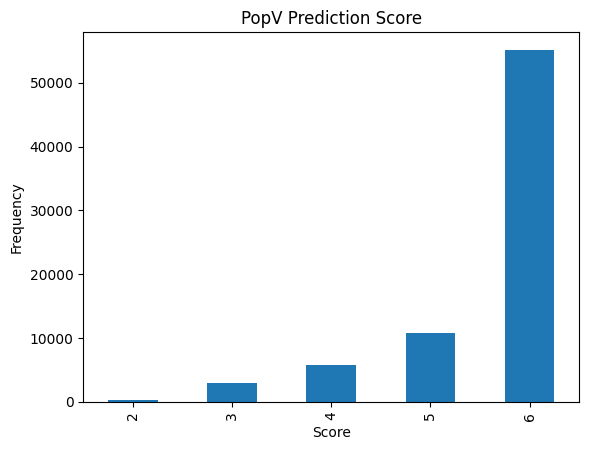

In [ ]:
popv.visualization.prediction_score_bar_plot(adata, popv_prediction_score="popv_prediction_score")

<AxesSubplot: ylabel='Mean Agreement'>

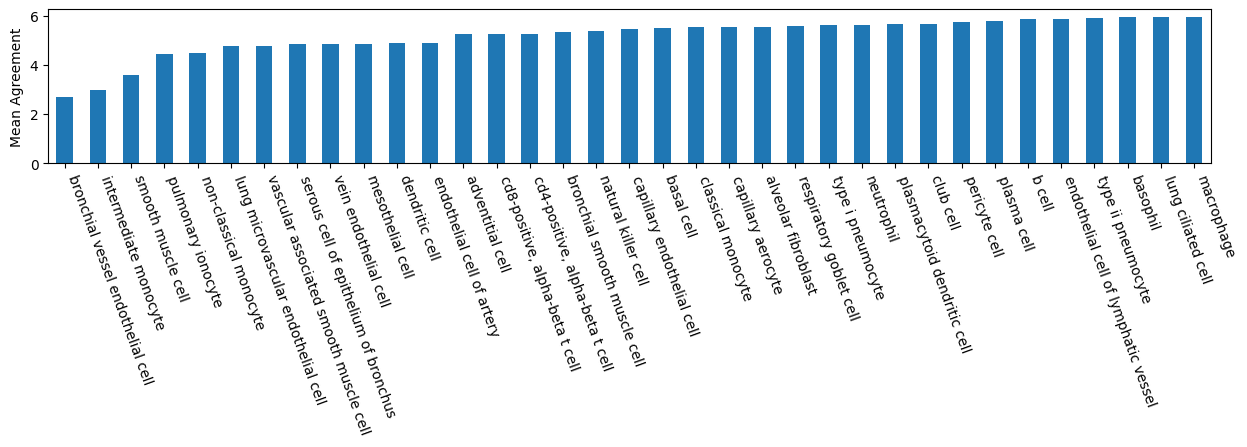

In [ ]:
popv.visualization.agreement_score_bar_plot(adata)

### Cell type proportion plot

<AxesSubplot: ylabel='log Celltype Abundance'>

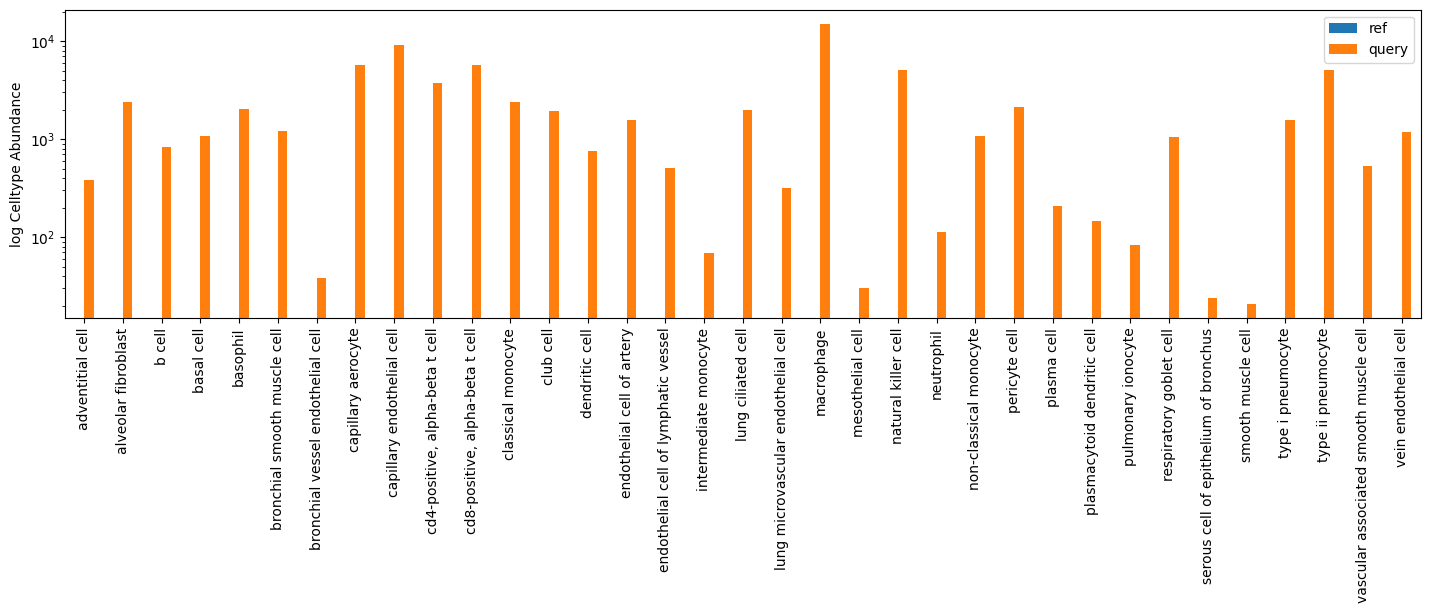

In [ ]:
popv.visualization.celltype_ratio_bar_plot(adata)